In [955]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt

# -- References to Relevant Papers --
# [1] Pezzé & Smerzi, "Heisenberg-limited noisy atomic clock using a hybrid coherent and squeezed states protocol", Phys. Rev. A, 2020.
#     - Discusses the hybrid quantum-classical protocol for enhanced metrology using coherent and squeezed states.
#     - Relevant equations and concepts used in the time evolution and squeezing operations are found in Sections II and III of the paper. [41†source].
#
# [2] Hayes et al., "Making the most of time in quantum metrology: concurrent state preparation and sensing", Quantum Sci. Technol., 2018.
#     - Introduces the idea of accounting for preparation, sensing, and measurement times in metrology protocols.
#     - The concept of fixed total time and the trade-off between preparation, sensing, and measurement is covered on page 2. [42†source].
#
# [3] "Entanglement-enhanced quantum metrology: From standard quantum limit to Heisenberg limit" (Pezzé et al.), Rev. Mod. Phys., 2018.
#     - Describes Fisher Information, phase variance, and the use of entanglement to improve precision in quantum sensing.
#     - The scaling of Fisher Information with particle number and entanglement is introduced on page 6 of the paper. [42†source].
#



In [956]:
N = 400
mu = (N**(-2/3))

In [957]:
# Constants
def sx_variance(S):
   # Define the A and B terms
   A = 1 - (np.cos(mu) ** (2 * S - 2))
   B = 4 * np.sin(mu / 2) * (np.cos( mu / 2) ** (2 * S - 2))

   # Define the main expression for ⟨ΔS²ₓ⟩
   return (S / 2) * (2 * S * (1 - np.cos(mu / 2)**(2*(2 * S - 1))) - (S - 0.5) * A)

# Output the result
for S in range(1,21):
   delta_Sx_square = sx_variance(S)
   print(f"\nS = {S} μ = {mu}: ⟨ΔS²ₓ⟩ = {delta_Sx_square}")



S = 1 μ = 0.018420157493201937: ⟨ΔS²ₓ⟩ = 8.482315208768743e-05

S = 2 μ = 0.018420157493201937: ⟨ΔS²ₓ⟩ = 0.0005088957451647724

S = 3 μ = 0.018420157493201937: ⟨ΔS²ₓ⟩ = 0.0012723472630081223

S = 4 μ = 0.018420157493201937: ⟨ΔS²ₓ⟩ = 0.0023756522939866187

S = 5 μ = 0.018420157493201937: ⟨ΔS²ₓ⟩ = 0.003819630238324906

S = 6 μ = 0.018420157493201937: ⟨ΔS²ₓ⟩ = 0.005605445015541

S = 7 μ = 0.018420157493201937: ⟨ΔS²ₓ⟩ = 0.0077346047720546485

S = 8 μ = 0.018420157493201937: ⟨ΔS²ₓ⟩ = 0.010208961588970222

S = 9 μ = 0.018420157493201937: ⟨ΔS²ₓ⟩ = 0.013030711190046285

S = 10 μ = 0.018420157493201937: ⟨ΔS²ₓ⟩ = 0.016202392649813102

S = 11 μ = 0.018420157493201937: ⟨ΔS²ₓ⟩ = 0.01972688810187262

S = 12 μ = 0.018420157493201937: ⟨ΔS²ₓ⟩ = 0.02360742244740177

S = 13 μ = 0.018420157493201937: ⟨ΔS²ₓ⟩ = 0.027847563063773617

S = 14 μ = 0.018420157493201937: ⟨ΔS²ₓ⟩ = 0.032451219513413065

S = 15 μ = 0.018420157493201937: ⟨ΔS²ₓ⟩ = 0.037422643252758014

S = 16 μ = 0.018420157493201937: ⟨ΔS²ₓ⟩ = 0.0427

In [958]:
def calculate_Delta_Sz_squared(S, axis):
   # Given parameters
   
   # Calculating A, B, and delta
   A = 1 - (np.cos(mu) ** (2 * S - 2))
   B = 4 * np.sin(mu / 2) * (np.cos( mu / 2) ** (2 * S - 2))
   delta = 0.5 * np.arctan(B / A)
   v = np.pi/2 - delta
   # Calculating the main formula
   term1 = S / 2
   subterm1 = A
   subterm2 = np.sqrt(A**2 + B**2) * np.cos(2 * v + 2 * delta)
   subterm = subterm1 + subterm2
   if axis == 'z':
      subterm = subterm1 - subterm2
   term2 = 0.5 * (S - 0.5) * (subterm)
   
   result = term1 * (term2 + 1)
   
   # # Printing result
   # print(A, B, delta, v, subterm1, subterm2, subterm, term1, term2, np.cos(2 * v + 2 * delta))
   # print ("S=", S,"A=", A,"B=", B)
   return result, A, B
# Example call (You will handle the axes part)

for axis in ['z', 'y']:
   print("")
   print("")
   print (f" ================= AXIS {axis} ================= ")
   for S in range(1,21):
      variance, A, B = calculate_Delta_Sz_squared(S, axis)
      print(f"\nS = {S} ⟨ΔS²{axis}⟩ = {variance} A = {A}, B = {B}")




 ================= AXIS z ================= 

S = 1 ⟨ΔS²z⟩ = 0.50460497426941 A = 0.0, B = 0.036839794155279534

S = 2 ⟨ΔS²z⟩ = 1.0278831215382787 A = 0.00033926382848226133, B = 0.03683666928781702

S = 3 ⟨ΔS²z⟩ = 1.5703466331140026 A = 0.0006784125570191701, B = 0.036833544685415616

S = 4 ⟨ΔS²z⟩ = 2.1325167110730727 A = 0.0010174462246599347, B = 0.03683042034805283

S = 5 ⟨ΔS²z⟩ = 2.714923546151055 A = 0.0013563648704407738, B = 0.036827296275706196

S = 6 ⟨ΔS²z⟩ = 3.3181062897545335 A = 0.0016951685333842503, B = 0.036824172468353226

S = 7 ⟨ΔS²z⟩ = 3.942613020150188 A = 0.0020338572524999377, B = 0.03682104892597144

S = 8 ⟨ΔS²z⟩ = 4.589000702899662 A = 0.0023724310667840864, B = 0.03681792564853836

S = 9 ⟨ΔS²z⟩ = 5.257835145622179 A = 0.0027108900152197357, B = 0.03681480263603152

S = 10 ⟨ΔS²z⟩ = 5.949690947179651 A = 0.003049234136776824, B = 0.03681167988842845

S = 11 ⟨ΔS²z⟩ = 6.665151441391526 A = 0.0033874634704118556, B = 0.03680855740570667

S = 12 ⟨ΔS²z⟩ = 7.40480863

/var/folders/3j/grhshysx2qb2lnsvc18r_g0c0000gn/T/ipykernel_91489/2930535283.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  delta = 0.5 * np.arctan(B / A)


In [959]:
# Adjusting the formula for A and B with the corrected powers
S = 20
A = 1 - np.cos(mu)**(2 * S - 2)
B = 4 * np.sin(mu / 2) * np.cos(mu / 2)**(2 * S - 2)
print(A,B)
# Recalculating V+ and V-
V_plus = (S / 2) * ((1 + (1 / 2) * (S - 1 / 2) * A) + (1 / 2) * (S - 1 / 2) * np.sqrt(A**2 + B**2))
V_minus = (S / 2) * ((1 + (1 / 2) * (S - 1 / 2) * A) - (1 / 2) * (S - 1 / 2) * np.sqrt(A**2 + B**2))

V_plus, V_minus


0.006426368437937646 0.036780466977162314


(np.float64(14.266992913817273), np.float64(6.986148931580569))

In [960]:
# Parameters for preparation, sensing, and measurement times
T_total = 1.0  # Total fixed time for the experiment

# Fraction of time allocated for preparation and measurement
tau_prep_fraction = 0.1  # Fraction of time spent on preparation
tau_meas_fraction = 0.05  # Fraction of time spent on measurement
tau_sense_fraction = 1 - tau_prep_fraction - tau_meas_fraction  # Remaining time for sensing
# mu = 0.199
# mu = 0.199
import math
# Operator for J_n in y-z plane
def J_n(theta, Jy, Jz):
    return Jy * np.cos(theta) + Jz * np.sin(theta)

# Spin squeezing formula
def spin_squeezing(N, Jy, Jz, state):
    # Minimize the variance by scanning over theta
    theta_values = np.linspace(0, 2 * np.pi, 100)
    min_variance = np.inf
    for theta in theta_values:
        Jn = J_n(theta, Jy, Jz)
        var_n = qt.variance(Jn, state)
        if var_n < min_variance:
            min_variance = var_n
    # Calculate the spin squeezing parameter
    return 4 * min_variance / N

def get_squeezed_state(N, Jy, Jz, state):
    chi_values = np.linspace(0.001, 1.0, 5000)  # Range of chi t values to explore
    best_squeezing = np.inf
    best_chi_t = None
    best_squeezed_state = None
    # Loop over chi t values to find the best squeezing
    for i in range(0, len(chi_values)):
        chi = chi_values[i]
        squeezed_state = apply_squeezing_operator(chi, Jy) * state
        # squeezing_param = spin_squeezing(N, Jy, Jz, squeezed_state)
        variance = qt.variance(Jy, squeezed_state)
        # Find the best squeezing parameter for this N
         
        if i % 1250 == 0:
            print("variance", variance,"chi", chi)
        if variance < N/4.0:
            if chi <= 1/math.sqrt(N):
                best_squeezed_state = squeezed_state
                best_chi_t = chi
    # print("no good chi")
    return best_chi_t, best_squeezed_state

    # Return the best chi t value for this N
    # print(best_squeezing, best_chi_t)

# def optimal_theta(N):
#     return (24**1/6) * (N**(-2/3))

def optimal_theta(n):
    mu = (3**(1/6))*((n)**(-2/3))
    #mu = (3 **(1/6)) * (n**(-2/3))
    return (mu/2)
    #return 2 * np.e / (1 - 2 * np.e + 2 * np.e ** 2 - n + np.e * n)

# def hamiltonian_oat(n, sqeezing_angle = 0):
#     return sqeezing_angle / 2 * (j_x(n) * j_x(n))


# def unitary_oat(n, sqeezing_angle = 0):
#     m = -1j * hamiltonian_oat(n, sqeezing_angle=sqeezing_angle)
#     return expm(m.todense())

# def oat_state(n, squeezing_angle = 0):
#     return unitary_oat(n, sqeezing_angle=squeezing_angle).dot(css_ground(n))

def generate_coherent_state(j):
    """
    Generate a coherent spin state aligned along the x-axis.

    Based on the description of coherent states for metrology in Pezzé & Smerzi, Section III. [41†source].
    
    Parameters:
        j (float): Total spin quantum number (N/2).
    
    Returns:
        Qobj: Coherent spin state.
    """
    theta = np.pi / 2  # Aligned along the x-axis
    phi = 0  # No rotation around the z-axis
    return qt.spin_coherent(j, theta, phi)

def apply_squeezing_operator(squeezing_strength, Jy):
    """
    Apply a squeezing operator to the coherent state.

    The use of squeezing to improve phase sensitivity is discussed in Hayes et al., Section 2.2. [42†source].
    
    Parameters:
        j (float): Total spin quantum number.
        squeezing_strength (float): The strength of squeezing.
        Jy (Qobj): Spin operator along the y-axis.
    
    Returns:
        Qobj: Squeezing operator.
    """

    # print("squeezing strength", squeezing_strength)
    # squeezing_strength = chi * t
    squeezing_operator = (-1j * squeezing_strength * Jy**2).expm()
    return squeezing_operator

def time_evolve_state(H, state, t):
    """
    Perform time evolution of a quantum state under a Hamiltonian H for time t.

    Time evolution based on the Hamiltonian dynamics as outlined in Pezzé et al., Phys. Rev. A, 2020. Section II [41†source].
    
    Parameters:
        H (Qobj): Hamiltonian of the system.
        state (Qobj): Initial quantum state.
        t (float): Time of evolution.
    
    Returns:
        Qobj: Evolved quantum state after time t.
    """
    U = (-1j * H * t).expm()  # Time evolution operator U = exp(-i H t)
    return U * state

def measure_phase_variance(operator, state):
    """
    Measure the phase variance of the given state.

    Fisher Information and phase variance calculations are fundamental to quantum metrology, as discussed in Pezzé et al., Section III. [42†source].
    
    Parameters:
        operator (Qobj): Spin operator (typically Jz).
        state (Qobj): Quantum state (coherent or squeezed).
    
    Returns:
        float: Phase variance of the state.
    """
    return qt.variance(operator, state)

def calculate_fisher_information(N, sensing_time, is_entangled):
    """
    Calculate Fisher Information for both separable (SQL) and entangled (HL) states.

    This formula for Fisher Information scaling is adapted from Pezzé et al., Rev. Mod. Phys., 2018, page 6 [42†source].
    
    Parameters:
        N (int): Number of particles.
        sensing_time (float): The time spent in sensing.
        is_entangled (bool): If True, apply Heisenberg scaling for entangled states.
    
    Returns:
        float: Fisher Information.
    """
    if is_entangled:
        return N**2 * sensing_time**2  # Heisenberg scaling
    else:
        return N * sensing_time**2  # Standard Quantum Limit scaling

def calculate_r_value(F_sep, F_ent, total_time_sep, total_time_ent):
    """
    Calculate the metrological gain r, comparing separable and entangled strategies.

    This calculation is adapted from "Entanglement-enhanced quantum metrology", Section II. [42†source].
    
    Parameters:
        F_sep (float): Fisher Information for separable states.
        F_ent (float): Fisher Information for entangled states.
        total_time_sep (float): Total time for separable strategy.
        total_time_ent (float): Total time for entangled strategy.
    
    Returns:
        float: Metrological gain r.
    """
    return (F_ent / total_time_ent) / (F_sep / total_time_sep)

def calculate_tilde_Sx(Jz, Jplus, Jminus):
    """
    Calculate the modified spin operator S_x tilde as per the provided equation.

    Parameters:
    j (float): Total spin quantum number.
    mu (float): The parameter mu in the equation.
    
    Returns:
    Qobj: The operator S_x tilde.
    """
    # Define spin operators
    S_plus = Jplus  # Raising operator S_+
    S_minus = Jminus  # Lowering operator S_-
    S_z = Jz  # Spin operator S_z

    # Compute the exponentials with S_z
    exp_i_mu = (1j * mu * (S_z + 0.5 * qt.qeye(S_z.shape[0]))).expm()  # e^(i * mu * (S_z + 1/2))
    exp_neg_i_mu = (-1j * mu * (S_z + 0.5 * qt.qeye(S_z.shape[0]))).expm()  # e^(-i * mu * (S_z + 1/2))

    # Calculate the tilde S_x operator
    tilde_Sx = 0.5 * (S_plus * exp_i_mu + S_minus * exp_neg_i_mu)

    return tilde_Sx

def rotate(Jz, Jplus, Jminus, v, state):
    Jx = calculate_tilde_Sx(Jz, Jplus, Jminus)
    A = (1j * v * Jx).expm()
    B = (-1j * v * Jx).expm()
    print(f" A.dims {A.dims}, state.dims {state.dims}, B.dims {B.dims}")
    return A * state 

def calculate_S_bar(j, mu, nu):
    """
    Calculate the rotated spin operator S_bar based on the formula:
    S_bar = exp(i * nu * S_tilde_x) * S_tilde * exp(-i * nu * S_tilde_x)

    Parameters:
    j (float): Total spin quantum number.
    mu (float): The parameter mu for phase shifts in S_tilde.
    nu (float): The rotation angle for the unitary transformation.

    Returns:
    Qobj: The rotated spin operator S_bar.
    """
    # Define spin operators
    S_x = qt.jmat(j, 'x')  # S_x operator
    S_y = qt.jmat(j, 'y')  # S_y operator
    S_z = qt.jmat(j, 'z')  # S_z operator
    S_plus = qt.jmat(j, '+')  # Raising operator S_+
    S_minus = qt.jmat(j, '-')  # Lowering operator S_-

    # Define the S_tilde_x operator (twisted version of S_x)
    exp_i_mu = (1j * mu * (S_z + 0.5 * qt.qeye(S_z.shape[0]))).expm()  # e^(i * mu * (S_z + 1/2))
    exp_neg_i_mu = (-1j * mu * (S_z + 0.5 * qt.qeye(S_z.shape[0]))).expm()  # e^(-i * mu * (S_z + 1/2))
    S_tilde_x = 0.5 * (S_plus * exp_i_mu + S_minus * exp_neg_i_mu)

    # Use S_tilde_x in the rotation operator: exp(i * nu * S_tilde_x)
    rotation_operator = (1j * nu * S_tilde_x).expm()

    # Define the S_tilde operator (you can modify this as needed for your system)
    S_tilde = S_tilde_x  # Using S_tilde_x as S_tilde, but this can be changed to another operator if necessary

    # Calculate S_bar: exp(i * nu * S_tilde_x) * S_tilde * exp(-i * nu * S_tilde_x)
    S_bar = rotation_operator * S_tilde * rotation_operator.dag()

    return S_bar


In [961]:
# Function to compute the Husimi Q function over the theta and phi grid
def compute_husimi_q(J, coherent_state, n_theta=300, n_phi=600):
    theta = np.linspace(0, np.pi, n_theta)
    phi = np.linspace(0, 2 * np.pi, n_phi)
    theta_grid, phi_grid = np.meshgrid(theta, phi)

    Q_vals = np.zeros_like(theta_grid, dtype=np.float64)

    # Loop through the grid to compute the Husimi Q function
    for i in range(n_phi):  # Loop over n_phi for the correct axis (axis=1 in grid)
        for j in range(n_theta):  # Loop over n_theta for the correct axis (axis=0 in grid)
            test_state = qt.spin_coherent(J, theta_grid[i, j], phi_grid[i, j])
            Q_vals[i, j] = np.abs(test_state.dag() * coherent_state)**2

    # Normalize the Q function
    Q_vals /= np.max(Q_vals)

    return Q_vals, theta_grid, phi_grid

# Function to find the maximum overlap
def find_max_overlap(Q_vals, theta_grid, phi_grid):
    max_idx = np.unravel_index(np.argmax(Q_vals, axis=None), Q_vals.shape)
    max_theta = theta_grid[max_idx]
    max_phi = phi_grid[max_idx]

    # Convert to Cartesian coordinates (x, y, z)
    max_x = np.sin(max_theta) * np.cos(max_phi)
    max_y = np.sin(max_theta) * np.sin(max_phi)
    max_z = np.cos(max_theta)

    return max_x, max_y, max_z, max_theta, max_phi

# Function to plot the Bloch sphere and the Husimi Q function
def plot_husimi_q(Q_vals, theta_grid, phi_grid, max_coords):
    x = np.sin(theta_grid) * np.cos(phi_grid)
    y = np.sin(theta_grid) * np.sin(phi_grid)
    z = np.cos(theta_grid)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the Bloch sphere as a semi-transparent surface
    u, v = np.mgrid[0:2 * np.pi:100j, 0:np.pi:50j]
    sphere_x = np.sin(v) * np.cos(u)
    sphere_y = np.sin(v) * np.sin(u)
    sphere_z = np.cos(v)
    ax.plot_surface(sphere_x, sphere_y, sphere_z, color='gray', alpha=0.2, edgecolor='none')

    # Normalize the Q values for the colormap
    norm = plt.Normalize(Q_vals.min(), Q_vals.max())
    colors = plt.cm.jet(norm(Q_vals))

    # Plot the Husimi Q function on the sphere, mapping the colors
    sphere = ax.plot_surface(x, y, z, facecolors=colors, rstride=1, cstride=1, alpha=0.8, shade=False)

    # Plot the 3D axes centered on the Bloch sphere
    ax.plot([-1, 1], [0, 0], [0, 0], color='black', lw=2)  # X-axis
    ax.plot([0, 0], [-1, 1], [0, 0], color='black', lw=2)  # Y-axis
    ax.plot([0, 0], [0, 0], [-1, 1], color='black', lw=2)  # Z-axis

    # Plot the coherent state's position
    max_x, max_y, max_z = max_coords
    ax.scatter(max_x, max_y, max_z, color='black', s=100, zorder=9)

    # Set the colorbar, link it to the surface plot (sphere)
    mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
    mappable.set_array(Q_vals)
    cbar = plt.colorbar(mappable, ax=ax, shrink=0.6)
    cbar.set_label(r'$Q(\theta, \phi)$', fontsize=12)

    # X-axis: Line from (-1,0,0) to (1,0,0)
    ax.plot([0, 1.5], [0, 0], [0, 0], color='black', lw=1, zorder=10, linestyle='--')
    ax.text(1.5, 0, 0, 'X', color='black', fontsize=15, ha='center', va='center', zorder=10)

    # Y-axis: Line from (0,-1,0) to (0,1,0)
    ax.plot([0, 0], [0, 1.5], [0, 0], color='black', lw=1, zorder=10, linestyle='--')
    ax.text(0, 1.5, 0, 'Y', color='black', fontsize=15, ha='center', zorder=10)

    # Z-axis: Line from (0,0,-1) to (0,0,1)
    ax.plot([0, 0], [0, 0], [0, 1.1], color='black', lw=1, zorder=10, linestyle='--')
    ax.text(0, 0, 1.2, 'Z', color='black', fontsize=15, ha='center', zorder=10)

    # Customize the plot
    ax.set_xlabel('X-axis', fontsize=12)
    ax.set_ylabel('Y-axis', fontsize=12)
    ax.set_zlabel('Z-axis', fontsize=12)
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio

    # Set the view angle to ensure the "hottest" region is visible
    ax.view_init(elev=15, azim=45)  # Adjust the view if needed
    ax.set_axis_off()
    plt.tight_layout()

    # Show the plot
    plt.show()



In [962]:
import math
def calculate_phase_variances(N_max, omega, squeezing_strength, tau_prep_fraction, tau_meas_fraction, T_total):
    """
    Calculate phase variances and metrological gain r based on preparation, sensing, and measurement times.

    The trade-off between preparation, sensing, and measurement is described in Hayes et al., 2018 [42†source].
    
    Parameters:
        N_max (int): Maximum number of particles.
        omega (float): Frequency shift due to the local oscillator.
        squeezing_strength (float): Squeezing strength.
        tau_prep_fraction (float): Fraction of time for preparation.
        tau_meas_fraction (float): Fraction of time for measurement.
        T_total (float): Total fixed time.
    
    Returns:
        tuple: Phase variances for separable and entangled states, and metrological gain r.
    """
    phase_variance_sql = []
    phase_variance_hl = []
    r_values = []

    for N in range(1, N_max + 1):
        j = N / 2  # Total spin quantum number
        optimal_theta_j = optimal_theta(N)
        mu = optimal_theta_j * 2
        A = 1 - (np.cos(mu) ** (2 * j - 2))
        
        B = 4 * np.sin(mu / 2) * (np.cos( mu / 2) ** (2 * j - 2))
        delta = 0.5 * np.arctan(B / A)
        
        # delta = np.pi / 2
        v = -1 * delta
        print("delta", delta, "v", v)
        # Define collective spin operators
        Jplus = qt.jmat(j, '-')
        Jminus = qt.jmat(j, '-')
        Jx = qt.jmat(j, 'x')
        Jy = qt.jmat(j, 'y')
        Jz = qt.jmat(j, 'z')
        #rot_spin_oper = (1j * delta  *Jz).expm()*Jx* (-1j * delta  *Jz).expm()
        # Allocate time based on total T_total
        tau_prep_sep = tau_prep_fraction * T_total
        tau_meas_sep = tau_meas_fraction * T_total
        tau_sense_sep = T_total - tau_prep_sep - tau_meas_sep

        tau_prep_ent = tau_prep_fraction * T_total
        tau_meas_ent = tau_meas_fraction * T_total
        tau_sense_ent = T_total - tau_prep_ent - tau_meas_ent

        # Separable (SQL) Strategy
        coherent_state = generate_coherent_state(j)
        H_sense = omega * Jz  # Sensing Hamiltonian
        evolved_coherent_state = time_evolve_state(H_sense, coherent_state, tau_sense_sep)
        phase_var_coherent_sql = measure_phase_variance(Jy, coherent_state)
        phase_var_sensing_sql = measure_phase_variance(Jy, evolved_coherent_state)
        # phase_var_sql = abs(phase_var_sensing_sql - phase_var_coherent_sql)
        phase_var_sql = phase_var_sensing_sql

        phase_variance_sql.append(phase_var_sql)

        # Entangled (HL) Strategy
        # chi_values = np.linspace(0.01, 0.1, 100)
        
        # for optimal_theta_j in chi_values:
        # print("optimal theta", optimal_theta_j)
        squeezing_operator = apply_squeezing_operator(optimal_theta_j, Jy)
        # # rotating_squeezing_operator = apply_squeezing_operator(optimal_theta_j, Jy)

        # optimal_theta, squeezed_state = get_squeezed_state(N, Jy, Jz, coherent_state)
        squeezed_state = squeezing_operator * coherent_state
        # rotated_squeezed_state = rotating_squeezing_operator * coherent_state
        # evolved_squeezed_state = rotate(Jz, Jplus, Jminus, v, squeezed_state)
        # op = calculate_S_bar(j, mu, v)
        # evolved_squeezed_state = op @ squeezed_state
        # evolved_squeezed_state = squeezed_state
        rotate_operator = (-1j * v * Jx).expm()
        squeezed_state = rotate_operator * squeezed_state

        evolved_squeezed_state = time_evolve_state(H_sense, squeezed_state, tau_sense_ent)
        # rotated_evolved_squeezed_state = rot_spin_oper * evolved_squeezed_state
        # rotate_operator = (-1j * v * Jx).expm()
        # squeezed_state = rotate_operator * squeezed_state
        
        if N == N_max :
            print("A", A, "B", B)
            # Q_vals, theta_grid, phi_grid = compute_husimi_q(j, coherent_state)
            # max_x, max_y, max_z, max_theta, max_phi = find_max_overlap(Q_vals, theta_grid, phi_grid)
            # print(f'The highest overlap occurs at Cartesian coordinates (x, y, z):')
            # print(f'x = {max_x:.4f}, y = {max_y:.4f}, z = {max_z:.4f}')
            # print(f'The corresponding spherical coordinates (theta, phi):')
            # print(f'theta = {max_theta:.4f}, phi = {max_phi:.4f}')
            # # Step 4: Plot the Husimi Q function and the Bloch sphere
            # plot_husimi_q(Q_vals, theta_grid, phi_grid, (max_x, max_y, max_z))

            # Q_vals, theta_grid, phi_grid = compute_husimi_q(j, evolved_coherent_state)
            # max_x, max_y, max_z, max_theta, max_phi = find_max_overlap(Q_vals, theta_grid, phi_grid)
            # print(f'The highest overlap occurs at Cartesian coordinates (x, y, z):')
            # print(f'x = {max_x:.4f}, y = {max_y:.4f}, z = {max_z:.4f}')
            # print(f'The corresponding spherical coordinates (theta, phi):')
            # print(f'theta = {max_theta:.4f}, phi = {max_phi:.4f}')
            # # Step 4: Plot the Husimi Q function and the Bloch sphere
            # plot_husimi_q(Q_vals, theta_grid, phi_grid, (max_x, max_y, max_z))

            # Q_vals, theta_grid, phi_grid = compute_husimi_q(j, squeezed_state)
            # max_x, max_y, max_z, max_theta, max_phi = find_max_overlap(Q_vals, theta_grid, phi_grid)
            # print(f'The highest overlap occurs at Cartesian coordinates (x, y, z):')
            # print(f'x = {max_x:.4f}, y = {max_y:.4f}, z = {max_z:.4f}')
            # print(f'The corresponding spherical coordinates (theta, phi):')
            # print(f'theta = {max_theta:.4f}, phi = {max_phi:.4f}')
            # # Step 4: Plot the Husimi Q function and the Bloch sphere
            # plot_husimi_q(Q_vals, theta_grid, phi_grid, (max_x, max_y, max_z))

            # Q_vals, theta_grid, phi_grid = compute_husimi_q(j, evolved_squeezed_state)
            # max_x, max_y, max_z, max_theta, max_phi = find_max_overlap(Q_vals, theta_grid, phi_grid)
            # print(f'The highest overlap occurs at Cartesian coordinates (x, y, z):')
            # print(f'x = {max_x:.4f}, y = {max_y:.4f}, z = {max_z:.4f}')
            # print(f'The corresponding spherical coordinates (theta, phi):')
            # print(f'theta = {max_theta:.4f}, phi = {max_phi:.4f}')
            # # Step 4: Plot the Husimi Q function and the Bloch sphere
            # plot_husimi_q(Q_vals, theta_grid, phi_grid, (max_x, max_y, max_z))

            # Q_vals, theta_grid, phi_grid = compute_husimi_q(j, rotated_squeezed_state)
            # max_x, max_y, max_z, max_theta, max_phi = find_max_overlap(Q_vals, theta_grid, phi_grid)
            # print(f'The highest overlap occurs at Cartesian coordinates (x, y, z):')
            # print(f'x = {max_x:.4f}, y = {max_y:.4f}, z = {max_z:.4f}')
            # print(f'The corresponding spherical coordinates (theta, phi):')
            # print(f'theta = {max_theta:.4f}, phi = {max_phi:.4f}')
            # # Step 4: Plot the Husimi Q function and the Bloch sphere
            # plot_husimi_q(Q_vals, theta_grid, phi_grid, (max_x, max_y, max_z))
        phase_var_squeezed_hl = measure_phase_variance(Jy, squeezed_state)
        phase_var_sensed_hl = measure_phase_variance(Jy, evolved_squeezed_state)
        # phase_var_hl = abs(phase_var_sensed_hl - phase_var_squeezed_hl)
        phase_var_hl = phase_var_sensed_hl
        phase_variance_hl.append(phase_var_hl)
        print("N:", N, "SQL: ", phase_var_sql, " ,HL: ", phase_var_hl, " ,chi", optimal_theta_j,
            " ,A", A, " ,B", B, " ,tau_sense_ent:", tau_sense_ent," ,tau_sense_sep", tau_sense_sep)
        # Fisher Information
        F_sep = calculate_fisher_information(N, tau_sense_sep, is_entangled=False)
        F_ent = calculate_fisher_information(N, tau_sense_ent, is_entangled=True)

        # Calculate metrological gain r
        r_value = calculate_r_value(F_sep, F_ent, T_total, T_total)
        r_values.append(r_value)

    return np.array(phase_variance_sql), np.array(phase_variance_hl), np.array(r_values)

In [963]:
N_max = 100
N_values = np.arange(1, N_max + 1)

delta -0.49903342399759104 v 0.49903342399759104
N: 1 SQL:  0.10889443821305941  ,HL:  0.10889443821305947  ,chi 0.6004684775880014  ,A -1.7663717450229641  ,B 2.739299096846124  ,tau_sense_ent: 0.85  ,tau_sense_sep 0.85
delta 0.7853981633974483 v -0.7853981633974483
N: 2 SQL:  0.217788876426119  ,HL:  0.21433967488336914  ,chi 0.3782714373557254  ,A 0.0  ,B 1.4772586442896907  ,tau_sense_ent: 0.85  ,tau_sense_sep 0.85
delta 0.7116940600338599 v -0.7116940600338599
N: 3 SQL:  0.32668331463917855  ,HL:  0.3017866063075447  ,chi 0.2886751345948129  ,A 0.16208817230500694  ,B 1.0916112293464852  ,tau_sense_ent: 0.85  ,tau_sense_sep 0.85
delta 0.6694961046840262 v -0.6694961046840262
N: 4 SQL:  0.4355777528522373  ,HL:  0.3836298895852992  ,chi 0.23829607324923416  ,A 0.21045500425213293  ,B 0.8915802014882079  ,tau_sense_ent: 0.85  ,tau_sense_sep 0.85
delta 0.6398365795458025 v -0.6398365795458025
N: 5 SQL:  0.5444721910652981  ,HL:  0.4618998216785606  ,chi 0.20535733068261153  ,A 0.2293

/var/folders/3j/grhshysx2qb2lnsvc18r_g0c0000gn/T/ipykernel_91489/1157927166.py:30: RuntimeWarning: divide by zero encountered in scalar divide
  delta = 0.5 * np.arctan(B / A)


N: 51 SQL:  5.553616348866001  ,HL:  3.526322673943355  ,chi 0.043662650544966514  ,A 0.17061248704127152  ,B 0.1666252618629122  ,tau_sense_ent: 0.85  ,tau_sense_sep 0.85
delta 0.38492141553960746 v -0.38492141553960746
N: 52 SQL:  5.662510787079043  ,HL:  3.5929232379159544  ,chi 0.043101063306043914  ,A 0.16972698048131374  ,B 0.16452712734853586  ,tau_sense_ent: 0.85  ,tau_sense_sep 0.85
delta 0.38309477242464823 v -0.38309477242464823
N: 53 SQL:  5.7714052252923125  ,HL:  3.659625667079922  ,chi 0.04255719223061556  ,A 0.16886012033797526  ,B 0.16249447341013729  ,tau_sense_ent: 0.85  ,tau_sense_sep 0.85
delta 0.3813062997485132 v -0.3813062997485132
N: 54 SQL:  5.880299663504786  ,HL:  3.726431294150416  ,chi 0.04203015970619172  ,A 0.16801123593616285  ,B 0.16052407777481706  ,tau_sense_ent: 0.85  ,tau_sense_sep 0.85
delta 0.37955454921531173 v -0.37955454921531173
N: 55 SQL:  5.9891941017188515  ,HL:  3.7933413473872406  ,chi 0.04151914680823521  ,A 0.16717968977181563  ,B 0.15

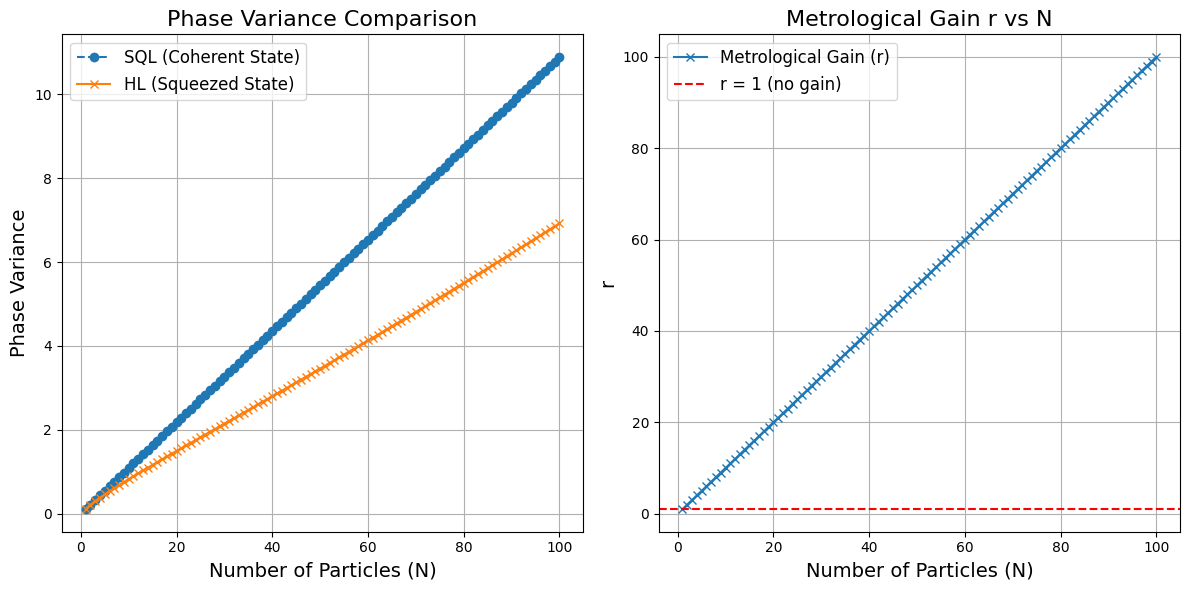

In [964]:
def plot_results(N_max, phase_variance_sql, phase_variance_hl, r_values):
    """
    Plot the phase variances and metrological gain r as a function of N.
    
    The scaling of phase variance and Fisher Information are discussed in Pezzé et al., Section III. [42†source].
    
    Parameters:
        N_max (int): Maximum number of particles.
        phase_variance_sql (np.array): Array of phase variances for SQL (Coherent State).
        phase_variance_hl (np.array): Array of phase variances for HL (Squeezed State).
        r_values (np.array): Array of metrological gain values.
    """
    plt.figure(figsize=(12, 6))

    # Plot phase variances
    plt.subplot(1, 2, 1)
    plt.plot(range(1, N_max+1), phase_variance_sql, label="SQL (Coherent State)", linestyle='--', marker='o')
    plt.plot(range(1, N_max+1), phase_variance_hl, label="HL (Squeezed State)", linestyle='-', marker='x')
    plt.title("Phase Variance Comparison", fontsize=16)
    plt.xlabel("Number of Particles (N)", fontsize=14)
    plt.ylabel("Phase Variance", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Plot metrological gain r
    plt.subplot(1, 2, 2)
    plt.plot(range(1, N_max+1), r_values, label="Metrological Gain (r)", linestyle='-', marker='x')
    plt.title("Metrological Gain r vs N", fontsize=16)
    plt.xlabel("Number of Particles (N)", fontsize=14)
    plt.ylabel("r", fontsize=14)
    plt.axhline(y=1, color='r', linestyle='--', label="r = 1 (no gain)")
    plt.legend(fontsize=12)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Parameters
omega = 1.0
squeezing_strength = mu/2
# Calculate phase variances and r values
phase_variance_sql, phase_variance_hl, r_values = calculate_phase_variances(N_max, omega, squeezing_strength, tau_prep_fraction, tau_meas_fraction, T_total)

# Plot the results
plot_results(N_max, phase_variance_sql, phase_variance_hl, r_values)

In [965]:
# def find_Nopt_and_showcase(N_max, omega, squeezing_strength, tau_prep_fraction, tau_meas_fraction, T_total):
#     """
#     Find the optimal N (N_opt) where entanglement is no longer useful.
#     Plot results showing how entanglement loses its advantage beyond N_opt.
    
#     Parameters:
#         N_max (int): Maximum number of particles to consider.
#         omega (float): Frequency shift due to local oscillator.
#         squeezing_strength (float): The squeezing strength for HL strategy.
#         tau_prep_fraction (float): Fraction of total time spent in preparation.
#         tau_meas_fraction (float): Fraction of total time spent in measurement.
#         T_total (float): Total available time for the experiment (fixed).
#     """
    
#     # Calculate phase variances and r values for the given range of N
#     phase_variance_sql, phase_variance_hl, r_values = calculate_phase_variances(
#         N_max, omega, squeezing_strength, tau_prep_fraction, tau_meas_fraction, T_total
#     )
    
#     # Find N_opt where entanglement stops being useful (r drops below 1)
#     N_opt = None
#     for N in range(1, N_max + 1):
#         if r_values[N - 1] < 1:
#             N_opt = N
#             break
    
#     # Plot the results
#     plt.figure(figsize=(12, 6))

#     # Plot phase variances
#     plt.subplot(1, 2, 1)
#     plt.plot(range(1, N_max+1), phase_variance_sql, label="SQL (Coherent State)", linestyle='--', marker='o')
#     plt.plot(range(1, N_max+1), phase_variance_hl, label="HL (Squeezed State)", linestyle='-', marker='x')
#     plt.title("Phase Variance Comparison", fontsize=16)
#     plt.xlabel("Number of Particles (N)", fontsize=14)
#     plt.ylabel("Phase Variance", fontsize=14)
#     plt.axvline(x=N_opt, color='r', linestyle='--', label=f"N_opt = {N_opt}")
#     plt.legend(fontsize=12)
#     plt.grid(True)

#     # # Plot metrological gain r
#     # plt.subplot(1, 2, 2)
#     # plt.plot(range(1, N_max+1), r_values, label="Metrological Gain (r)", linestyle='-', marker='x')
#     # plt.title("Metrological Gain r vs N", fontsize=16)
#     # plt.xlabel("Number of Particles (N)", fontsize=14)
#     # plt.ylabel("r", fontsize=14)
#     # plt.axhline(y=1, color='r', linestyle='--', label="r = 1 (no gain)")
#     # plt.axvline(x=N_opt, color='r', linestyle='--', label=f"N_opt = {N_opt}")
#     # plt.legend(fontsize=12)
#     # plt.grid(True)

#     plt.tight_layout()
#     plt.show()

#     if N_opt:
#         print(f"The optimal number of particles (N_opt) where entanglement stops being useful is: {N_opt}")
#     else:
#         print("Entanglement is beneficial for all N up to N_max.")

# # Parameters
# N_max = 40
# omega = 1.0
# squeezing_strength = 0.5
# T_total = 1.0  # Total available time for experiment
# tau_prep_fraction = 0.5   # Fraction of time for preparation
# tau_meas_fraction = 0.05  # Fraction of time for readout

# # Find N_opt and showcase the results
# find_Nopt_and_showcase(N_max, omega, squeezing_strength, tau_prep_fraction, tau_meas_fraction, T_total)


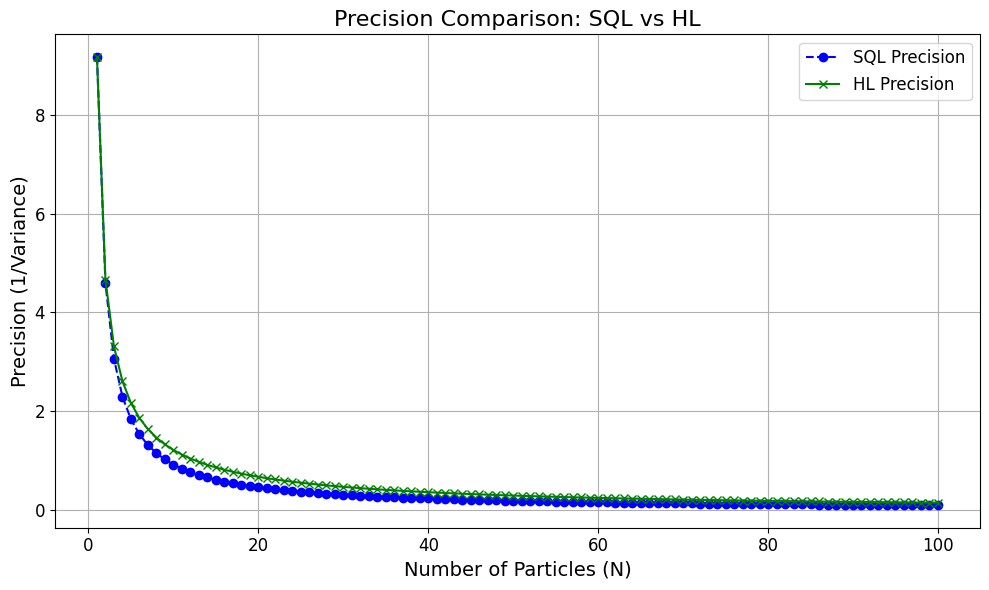

In [966]:
# Calculate precision as 1/variance
precision_sql = 1 / phase_variance_sql
precision_hl = 1 / phase_variance_hl

# Plot precision vs. N
plt.figure(figsize=(10, 6))
plt.plot(N_values, precision_sql, label="SQL Precision", linestyle='--', marker='o', color='blue')
plt.plot(N_values, precision_hl, label="HL Precision", linestyle='-', marker='x', color='green')

plt.title("Precision Comparison: SQL vs HL", fontsize=16)
plt.xlabel("Number of Particles (N)", fontsize=14)
plt.ylabel("Precision (1/Variance)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


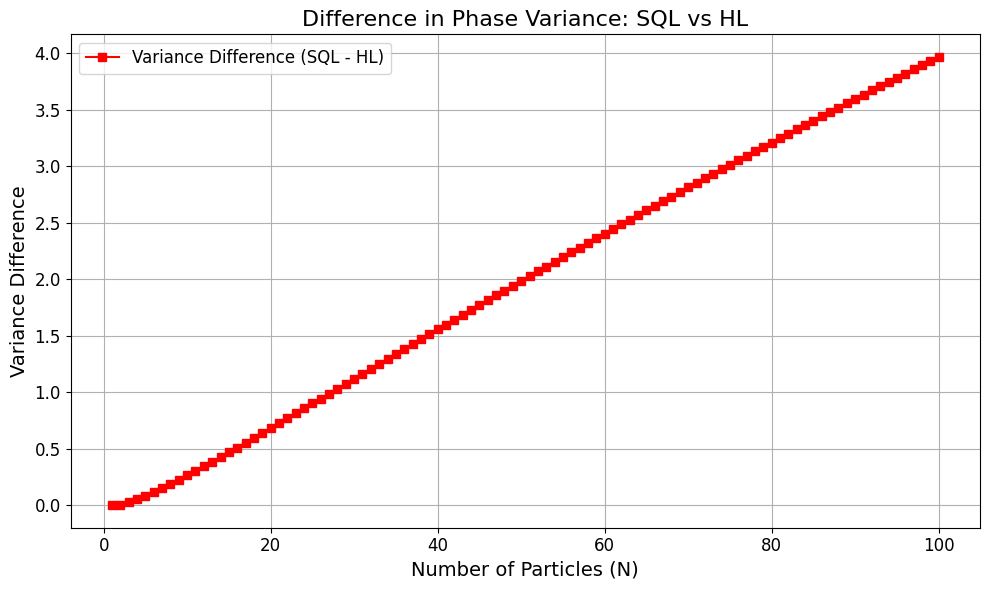

In [967]:
# Difference in variance (SQL - HL)
variance_diff = phase_variance_sql - phase_variance_hl

# Plot difference in variance
plt.figure(figsize=(10, 6))
plt.plot(N_values, variance_diff, label="Variance Difference (SQL - HL)", linestyle='-', marker='s', color='red')

plt.title("Difference in Phase Variance: SQL vs HL", fontsize=16)
plt.xlabel("Number of Particles (N)", fontsize=14)
plt.ylabel("Variance Difference", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


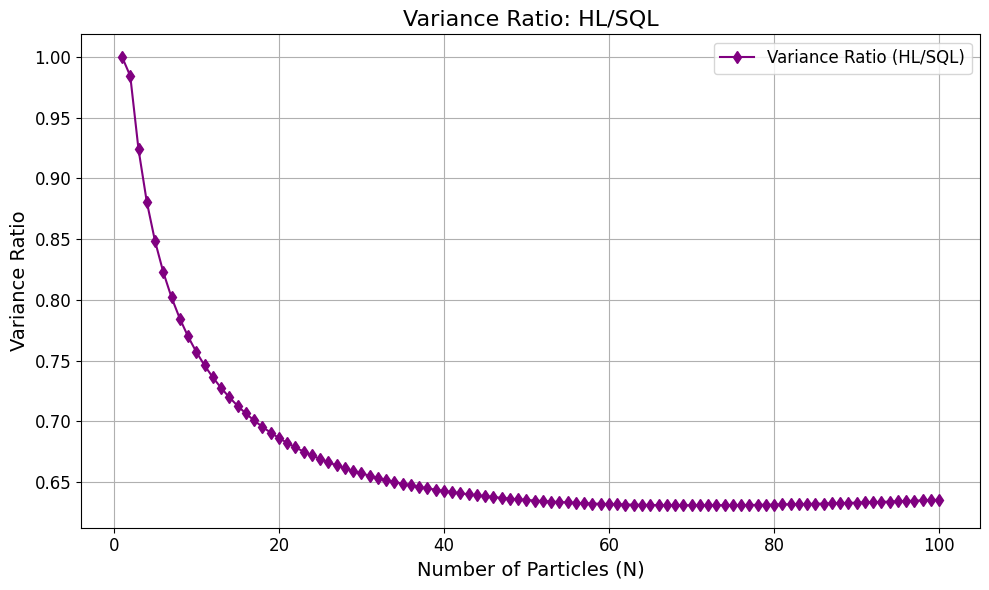

In [968]:
# Ratio of HL variance to SQL variance
variance_ratio = phase_variance_hl / phase_variance_sql

# Plot variance ratio
plt.figure(figsize=(10, 6))
plt.plot(N_values, variance_ratio, label="Variance Ratio (HL/SQL)", linestyle='-', marker='d', color='purple')

plt.title("Variance Ratio: HL/SQL", fontsize=16)
plt.xlabel("Number of Particles (N)", fontsize=14)
plt.ylabel("Variance Ratio", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


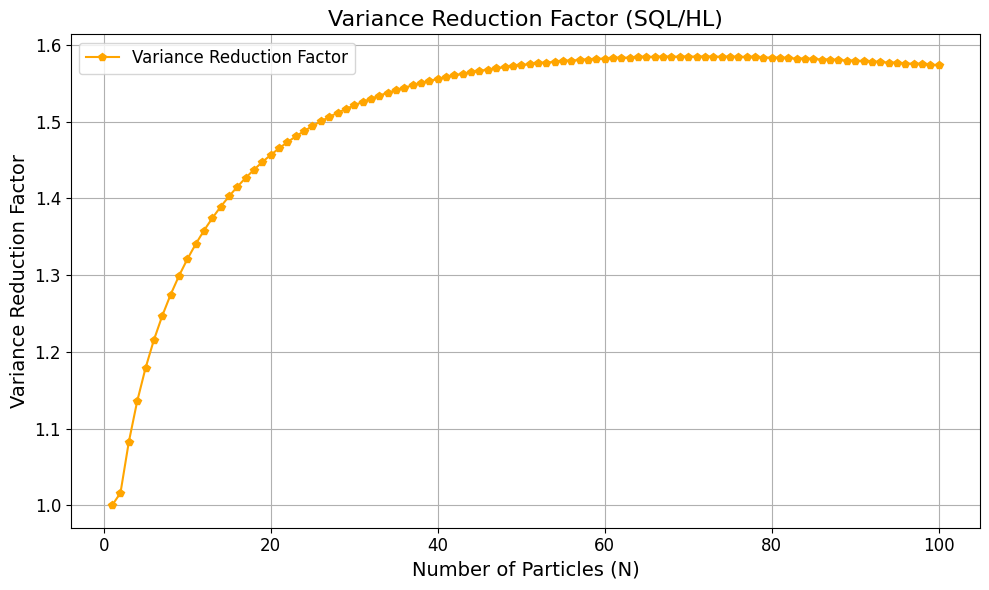

In [969]:
# Variance reduction factor: SQL variance / HL variance
variance_reduction_factor = phase_variance_sql / phase_variance_hl

# Plot variance reduction factor
plt.figure(figsize=(10, 6))
plt.plot(N_values, variance_reduction_factor, label="Variance Reduction Factor", linestyle='-', marker='p', color='orange')

plt.title("Variance Reduction Factor (SQL/HL)", fontsize=16)
plt.xlabel("Number of Particles (N)", fontsize=14)
plt.ylabel("Variance Reduction Factor", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()
